## 知識情報学第7回演習サンプルプログラム ex7.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2020/11/24
- Checked with Python 3.8, scikit-learn 0.23.2
- MIT License

## 多層パーセプトロンによる手書き文字認識
- (注)scikit-learn 0.18以降ではMLPが実装されているが，ここではLossの履歴を出力できる外部のプログラムを利用する

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from neuralnet import NeuralNetMLP
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

### MNISTデータの読み込み関数

In [2]:
def load_mnist(path, kind='train'):

    labels_path = os.path.join(path,"data/"+'%s-labels.idx1-ubyte'% kind)
    images_path = os.path.join(path,"data/"+'%s-images.idx3-ubyte'% kind)
   
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [3]:
# MNISTデータの読み込み
current_path = os.path.dirname(os.path.realpath('__file__'))
X_train, y_train = load_mnist(current_path, kind='train')
X_test, y_test = load_mnist(current_path, kind='t10k')

In [4]:
# 学習データとテストデータは最初の1000個用いる
n_training_data = 1000
n_test_data = 1000

X_trn = X_train[:n_training_data][:]
y_trn = y_train[:n_training_data][:]
X_tst = X_test[:n_test_data][:]
y_tst = y_test[:n_test_data][:]

### 多層パーセプトロン(MLP)のインスタンスの生成と学習

In [5]:
nn = NeuralNetMLP(n_output=10,              # 出力ユニット数
                  n_features=784,  # 入力ユニット数
                  n_hidden=30,              # 隠れユニット数
                  l2=2.0,                   # L2正則化のλパラメータ
                  l1=0.0,                   # L1正則化のλパラメータ
                  epochs=300,               # 学習エポック数
                  eta=0.001,                # 学習率の初期値
                  alpha = 0.001,            # モーメンタム学習の1つ前の勾配の係数
                  decrease_const=0.00001,   # 適応学習率の減少定数
                  minibatches=10,           # 各エポックでのミニバッチ数
                  shuffle=True,             # データのシャッフル
                  random_state=1)           # 乱数シードの状態                  

### 課題1(a) 学習データおよびテストデータに対するAccuracyの算出

In [6]:
nn.fit(X_trn, y_trn, X_tst, y_tst,print_progress = True)

Epoch: 300 / 300

In [7]:
y_trn_pred = nn.predict(X_trn)
y_tst_pred = nn.predict(X_tst)

In [8]:
train_acc = accuracy_score(y_trn_pred, y_trn)
test_acc = accuracy_score(y_tst_pred, y_tst)

学習データ，テストデータに対する正答率

In [9]:
print("訓練性能 : {:.3}%".format(train_acc))
print("テスト性能 : {:.3}%".format(test_acc))

訓練性能 : 0.935%
テスト性能 : 0.816%


### 課題1(b) 学習曲線のプロット
- ヒント：損失関数値の履歴はcost_に格納されている

ミニバッチを10分割として設定していたので長さ3000の損失関数の履歴を表すリストが格納されている

バリデーションデータに対する過学習についても確認したいので， neuralnet.py を書き換えてself.cost_val_にバリデーションデータ(テストデータ)に対する損失関数を評価できるように書き換える

In [10]:
train_hist = nn.cost_
test_hist = nn.cost_val_

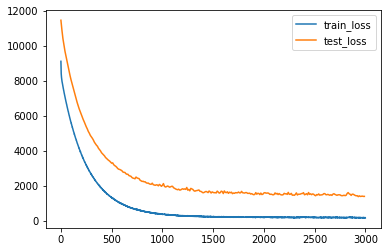

In [11]:
plt.plot(range(len(train_hist)), train_hist, label = 'train_loss')
plt.plot(range(0,len(train_hist), int(len(train_hist)/len(test_hist))), test_hist, label = 'test_loss')
plt.legend()

### 課題1(c) PCAにより次元圧縮を行い，圧縮後の空間でMLPにより学習するように変更する．

ひとまず二次元に圧縮してどの程度分類できているのかを確認する．

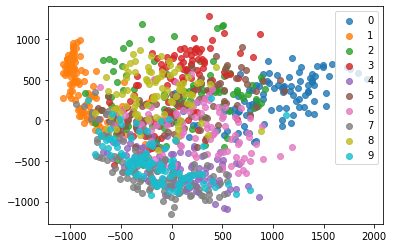

In [12]:
pca = PCA(n_components=2)
pca.fit(X_trn)
Xd = pca.transform(X_trn)
for i in range(10):
    idx = np.where(y_trn == i)
    plt.scatter(Xd[idx,0],Xd[idx,1],alpha=0.8, label = i)
plt.legend()

可視化の結果より二次元に圧縮してしまうとあまり分類できなさそうなことが予想される.  
実際多層パーセプトロンによって分類を行うと以下のような結果となる．

In [13]:
def pca_nn(n_components):
    
    pca = PCA(n_components=n_components)
    pca.fit(X_trn)
    pca_X_trn = pca.transform(X_trn)
    pca_X_tst = pca.transform(X_tst)
    nn = NeuralNetMLP(n_output=10,              # 出力ユニット数
                  n_features=n_components,  # 入力ユニット数
                  n_hidden=30,              # 隠れユニット数
                  l2=2.0,                   # L2正則化のλパラメータ
                  l1=0.0,                   # L1正則化のλパラメータ
                  epochs=300,               # 学習エポック数
                  eta=0.001,                # 学習率の初期値
                  alpha = 0.001,            # モーメンタム学習の1つ前の勾配の係数
                  decrease_const=0.00001,   # 適応学習率の減少定数
                  minibatches=10,           # 各エポックでのミニバッチ数
                  shuffle=True,             # データのシャッフル
                  random_state=1)           # 乱数シードの状態                  
    nn.fit(pca_X_trn, y_trn, pca_X_tst, y_tst,print_progress = True)
    pca_y_trn_pred = nn.predict(pca_X_trn)
    pca_y_tst_pred = nn.predict(pca_X_tst)
    train_acc = accuracy_score(pca_y_trn_pred, y_trn)
    test_acc = accuracy_score(pca_y_tst_pred, y_tst)
    print("訓練性能 : {:.3}%".format(train_acc))
    print("テスト性能 : {:.3}%".format(test_acc))

In [14]:
pca_nn(2)

Epoch: 300 / 300

訓練性能 : 0.431%
テスト性能 : 0.384%


予想通り二次元に圧縮するとうまく分類できないことが確認できる．  
続いて，今回は10クラス分類であったので，10クラスに次元圧縮した際にどのような制度となるのかを確認する

In [15]:
pca_nn(10)

Epoch: 300 / 300

訓練性能 : 0.84%
テスト性能 : 0.737%


結果より，784次元を10次元に圧縮したとしてもかなり良い精度を示すことがわかる．  

### 課題2: 隠れノード数，主成分数，学習データ数を変化させてAccuracyと収束性について考察しなさい．

In [16]:
def trainer(n_hidden=30,n_components=None,l2=2.0,l1=0.0,num_data = 1000, epoch = 300, eta = 0.001, decrease_const=0.00001):
    n_training_data = min(len(X_train), num_data)
    n_test_data = 10000

    X_trn = X_train[:n_training_data][:]
    y_trn = y_train[:n_training_data][:]
    X_tst = X_test[:n_test_data][:]
    y_tst = y_test[:n_test_data][:]
    
    if n_components is None:
        pca_X_trn = X_trn
        pca_X_tst = X_tst
        n_input = 784
    else:        
        pca = PCA(n_components=n_components)
        pca.fit(X_trn)
        pca_X_trn = pca.transform(X_trn)
        pca_X_tst = pca.transform(X_tst)
        n_input = n_components
    nn = NeuralNetMLP(n_output=10,              # 出力ユニット数
                  n_features=n_input,  # 入力ユニット数
                  n_hidden=n_hidden,              # 隠れユニット数
                  l2=l2,                   # L2正則化のλパラメータ
                  l1=l1,                   # L1正則化のλパラメータ
                  epochs=epoch,               # 学習エポック数
                  eta=eta,                # 学習率の初期値
                  alpha = 0.001,            # モーメンタム学習の1つ前の勾配の係数
                  decrease_const=decrease_const,   # 適応学習率の減少定数
                  minibatches=10,           # 各エポックでのミニバッチ数
                  shuffle=True,             # データのシャッフル
                  random_state=1)           # 乱数シードの状態                  
    nn.fit(pca_X_trn, y_trn, pca_X_tst, y_tst,print_progress = True)
    pca_y_trn_pred = nn.predict(pca_X_trn)
    pca_y_tst_pred = nn.predict(pca_X_tst)
    train_acc = accuracy_score(pca_y_trn_pred, y_trn)
    test_acc = accuracy_score(pca_y_tst_pred, y_tst)    
    return train_acc, test_acc, nn.cost_, nn.cost_val_

## 隠れノード数

まず初めに隠れノード数について変化させた時のAccuracyと収束性について考察を行う

In [17]:
num_hidden_nodes = [2,10,30,50,100,200,500,784]
train_acc = []
test_acc = []
train_hist = []
test_hist = []
for node in num_hidden_nodes:
    trn_acc, tst_acc, trn_hist, tst_hist = trainer(n_hidden = node)
    train_acc.append(trn_acc)
    test_acc.append(tst_acc)
    train_hist.append(trn_hist)
    test_hist.append(tst_hist)

Epoch: 1 / 30000/Users/atsu/Desktop/repos/KnowledgeInformation/No7/neuralnet.py:187: RuntimeWarning: divide by zero encountered in log
  term2 = (1 - y_enc) * np.log(1 - output)
Epoch: 1 / 30000/Users/atsu/Desktop/repos/KnowledgeInformation/No7/neuralnet.py:187: RuntimeWarning: divide by zero encountered in log
  term2 = (1 - y_enc) * np.log(1 - output)
Epoch: 300 / 300

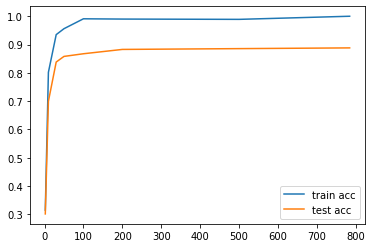

In [18]:
plt.plot(num_hidden_nodes, train_acc, label = 'train acc')
plt.plot(num_hidden_nodes, test_acc, label = 'test acc')
plt.legend()

グラフより，隠れノードが増えるにつれて訓練性能，テスト性能どちらも向上することが見て取れる．  
これは中間層のノード数が多くなることで多層パーセプトロンが作る関数が表現できる集合(仮説集合)が大きくなり，よりデータにフィットすることができるためだと考えられる.  
一般には仮説集合が大きくなると過学習が起こり，汎化性能が落ちるが，今回使ったモデルは非線形変換が一回のみの比較的線形モデルに近いものであったため，過学習の影響は受けなかったと推察される．

In [19]:
def plot_loss(train_hist, test_hist):
    plt.plot(range(len(train_hist)), train_hist, label = 'train_loss')
    plt.plot(range(0,len(train_hist), int(len(train_hist)/len(test_hist))), test_hist, label = 'test_loss')
    plt.legend()

100ノードの時の学習曲線

(0.0, 50000.0)

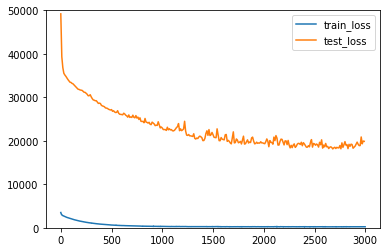

In [20]:
plot_loss(train_hist[1], test_hist[1])
plt.ylim(0,50000)

(0.0, 50000.0)

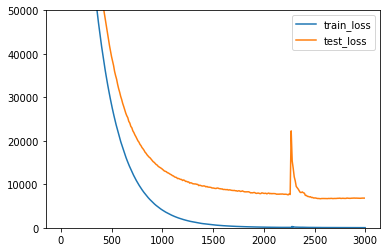

In [21]:
plot_loss(train_hist[-1], test_hist[-1])
plt.ylim(0,50000)

## 主成分数

続いて主成分分析において主成分数を変化させた際にどのように性能，収束性に影響が出るのかについて議論を行う

In [22]:
num_comp = [2,10,30,50,100,200,500,784]
train_acc = []
test_acc = []
train_hist = []
test_hist = []
for np in num_comp:
    trn_acc, tst_acc, trn_hist, tst_hist = trainer(n_components=np)
    train_acc.append(trn_acc)
    test_acc.append(tst_acc)
    train_hist.append(trn_hist)
    test_hist.append(tst_hist)

Epoch: 300 / 300

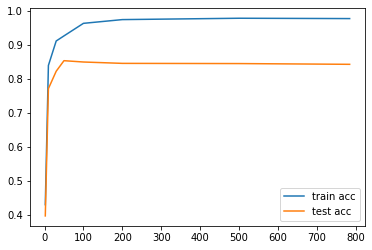

In [23]:
plt.plot(num_comp, train_acc, label = 'train acc')
plt.plot(num_comp, test_acc, label = 'test acc')
plt.legend()

グラフより，主成分数が100近くの段階で既に主成分分析を用いない場合の784次元の性能と同等の性能を出すことができている．  
これは入力次元が784次元であるが実質的には100次元程度で分類できるくらいの自由度しか持たない(データがR^{100}の多様体上に分布している)データセットであることを示唆している．  

Text(0.5, 1.0, '100dim reduction')

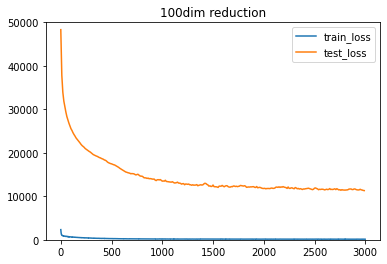

In [24]:
plot_loss(train_hist[3], test_hist[3])
plt.ylim(0,50000)
plt.title("100dim reduction")

Text(0.5, 1.0, 'no dimension reduction')

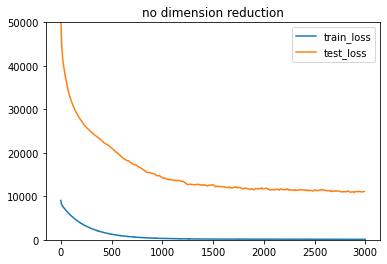

In [25]:
plot_loss(train_hist[-1], test_hist[-1])
plt.ylim(0,50000)
plt.title("no dimension reduction")

また収束性については前問同様， 次元圧縮するとそれだけモデルとしては小さくなるので，早く収束することが見て取れる

ここで，主成分分析の累積寄与率を見る. 

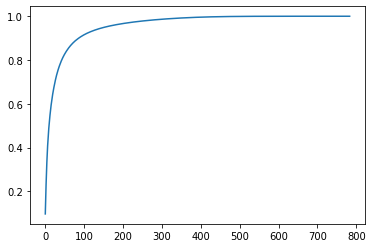

In [26]:
import numpy as np
pca = PCA()
pca.fit(X_train)
accumulated_ratio_ = np.add.accumulate(pca.explained_variance_ratio_)
plt.plot(accumulated_ratio_)

グラフより，100次元の次元圧縮の時点で9割近くの情報を復元することができている．  
これは100次元の圧縮をおこなった際に784次元の元の次元での学習結果とほぼ同じ性能が出ていることとも整合性がある．  
実際に訓練性能，テスト性能のグラフでは784次元よりも100次元に圧縮した際の性能の方が良かった．  
これは次元圧縮をすることである種の正則化の役割が果たされていることを示唆している．

## データ数

In [27]:
num_data = [784, 1000,3000,5000,8000,10000]
train_acc = []
test_acc = []
train_hist = []
test_hist = []
for nd in num_data:
    trn_acc, tst_acc, trn_hist, tst_hist = trainer(num_data=nd)
    train_acc.append(trn_acc)
    test_acc.append(tst_acc)
    train_hist.append(trn_hist)
    test_hist.append(tst_hist)

Epoch: 300 / 300

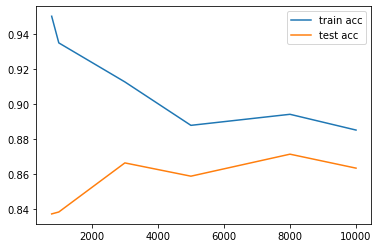

In [28]:
plt.plot(num_data, train_acc, label = 'train acc')
plt.plot(num_data, test_acc, label = 'test acc')
plt.legend()

グラフよりデータ数が多くなるにつれてテスト誤差が少なくなっていき，汎化性能が高まっていることが確認できる．  
一方で，訓練誤差が悪くなっているのはデータ数が多くなったことで少なかった時と同じエポック数300では学習しきれなかったことを示している.

実際，損失関数曲線を描くと以下のようになり， データ数を10000とした時の方が，損失曲線の傾きが大きく，まだ損失関数値が改善する見込みがあることを示唆している．

Text(0.5, 1.0, '1000 data sets')

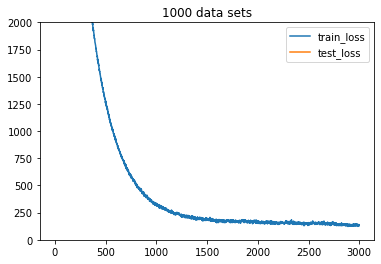

In [29]:
plot_loss(train_hist[0], test_hist[0])
plt.ylim(0,2000)
plt.title("1000 data sets")

Text(0.5, 1.0, '10000 data sets')

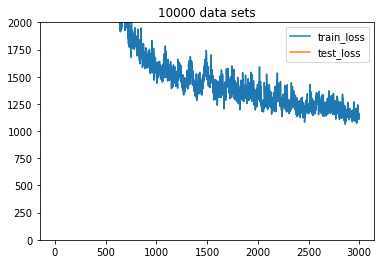

In [30]:
plot_loss(train_hist[-1], test_hist[-1])
plt.ylim(0,2000)
plt.title("10000 data sets")

## 追加考察 L2正則化と汎化性能

In [31]:
lams = [0, 0.1, 0.5, 1, 3, 5]
train_acc = []
test_acc = []
train_hist = []
test_hist = []
for lam in lams:
    trn_acc, tst_acc, trn_hist, tst_hist = trainer(l2 = lam, epoch = 1000)
    train_acc.append(trn_acc)
    test_acc.append(tst_acc)
    train_hist.append(trn_hist)
    test_hist.append(tst_hist)

Epoch: 1000 / 1000

L2正則化の増加とともに訓練性能，テスト性能がどのように推移するのかを示した図が以下である．  
グラフより，L2正則化を適切にかけることで，汎化性能が向上していることが見て取れる

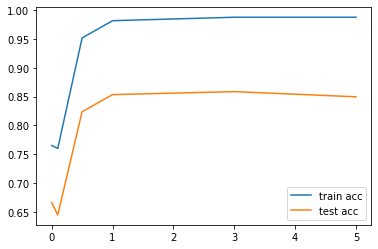

In [32]:
plt.plot(lams, train_acc, label = 'train acc')
plt.plot(lams, test_acc, label = 'test acc')
plt.legend()

Text(0.5, 1.0, 'lambda = 0')

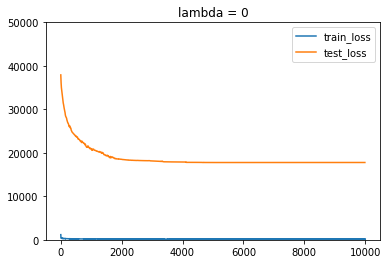

In [33]:
plot_loss(train_hist[0], test_hist[0])
plt.ylim(0,50000)
plt.title("lambda = 0")

Text(0.5, 1.0, 'lambda = 5')

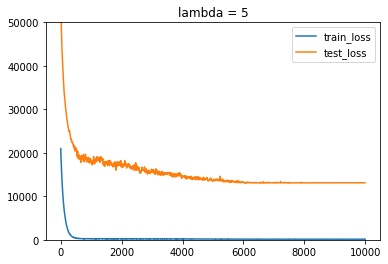

In [34]:
plot_loss(train_hist[-1], test_hist[-1])
plt.ylim(0,50000)
plt.title("lambda = 5")

今回は中間層一層の簡単なモデルであったために過学習のようなことは起こらなかったが，層を深くしていくと訓練，テスト損失関数曲線がエポックが進むごとに乖離していく．  
そのような場合にL2正則化項を入れることで過学習を防ぎ汎化性能を高めることができる．  